<a href="https://colab.research.google.com/github/Ram5268/ECON3916-Statistical-Machine-Learning/blob/main/Assignment%201/Econ_3916_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
# Manual Data Construction
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {'Item': 'Spotify Subscription', 'Price_2016': 9.99, 'Price_2024': 11.99},
]

In [68]:
# Define the "Machine" (Function)
def calculate_inflation (base, current):
  return ((current-base) / base) * 100

# Run the Loop
for item in student_basket:
  rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
  print(f"{item['Item']}: {rate:.2f}% Inflation")

Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
Spotify Subscription: 20.02% Inflation


In [69]:
!pip install fredapi
from fredapi import Fred
fred = Fred(api_key='41fa4f7ea9035728fe92a1c19e85aab8')
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
official_cpi = fred.get_series('CPIAUCSL')
tuition = fred.get_series('CUSR0000SEEB')
rent = fred.get_series('CUSR0000SEHA')
streaming = fred.get_series('CUSR0000SERA02')
food = fred.get_series('CUSR0000SEFV')

In [71]:
df = pd.DataFrame({
    'Official_CPI': official_cpi,
    'Tuition': tuition,
    'Rent': rent,
    'Streaming': streaming,
    'Food_Away': food
    })

df = df.loc['2016-01-01':].copy()

In [72]:
df_indexed = df.copy()
base = df_indexed.loc['2016-01-01']

for col in df_indexed.columns:
   df_indexed[col] = (df_indexed[col]/base[col]) * 100

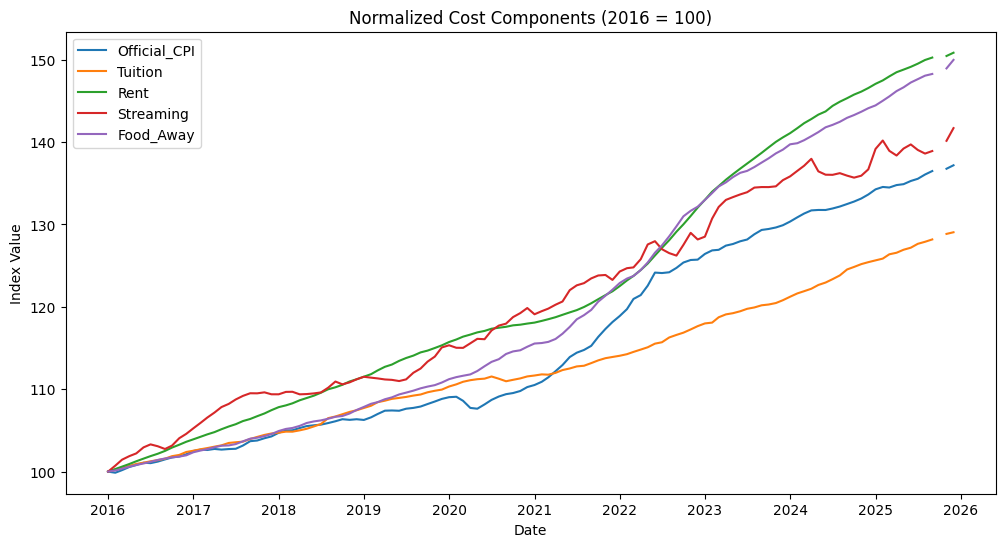

In [73]:
plt.figure(figsize=(12,6))

for col in df_indexed.columns:
  plt.plot(df_indexed.index, df_indexed[col], label=col)

plt.title("Normalized Cost Components (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.show()

In [74]:
weights = {
    'Tuition': 0.4,
    'Rent': 0.3,
    'Food_Away': 0.2,
    'Streaming': 0.1
}

df_indexed['Student_SPI'] = (
    df_indexed['Tuition'] * weights ['Tuition'] +
    df_indexed['Rent'] * weights ['Rent'] +
    df_indexed['Food_Away'] * weights ['Food_Away'] +
    df_indexed['Streaming'] * weights ['Streaming']
)

In [75]:
weights = {
    'Tuition': 0.4,
    'Rent': 0.3,
    'Food_Away': 0.2,
    'Streaming': 0.1
}

df_indexed['Student_SPI'] = (
    df_indexed['Tuition'] * weights ['Tuition'] +
    df_indexed['Rent'] * weights ['Rent'] +
    df_indexed['Food_Away'] * weights ['Food_Away'] +
    df_indexed['Streaming'] * weights ['Streaming']
)

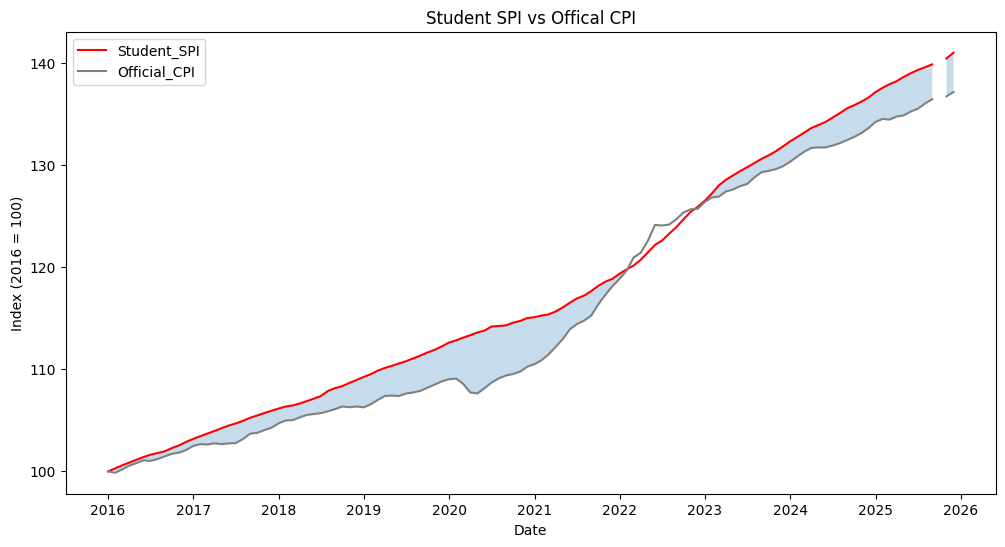

In [76]:
plt.figure(figsize=(12,6))

plt.plot(df_indexed.index, df_indexed['Student_SPI'], label='Student_SPI', color='red')
plt.plot(df_indexed.index, df_indexed['Official_CPI'], label='Official_CPI', color= 'Gray')

plt.fill_between(
    df_indexed.index,
    df_indexed['Student_SPI'],
    df_indexed['Official_CPI'],
    where=(df_indexed['Student_SPI'] > df_indexed['Official_CPI']),
    alpha=0.25
)

plt.title("Student SPI vs Offical CPI")
plt.xlabel("Date")
plt.ylabel("Index (2016 = 100)")
plt.legend()
plt.show()

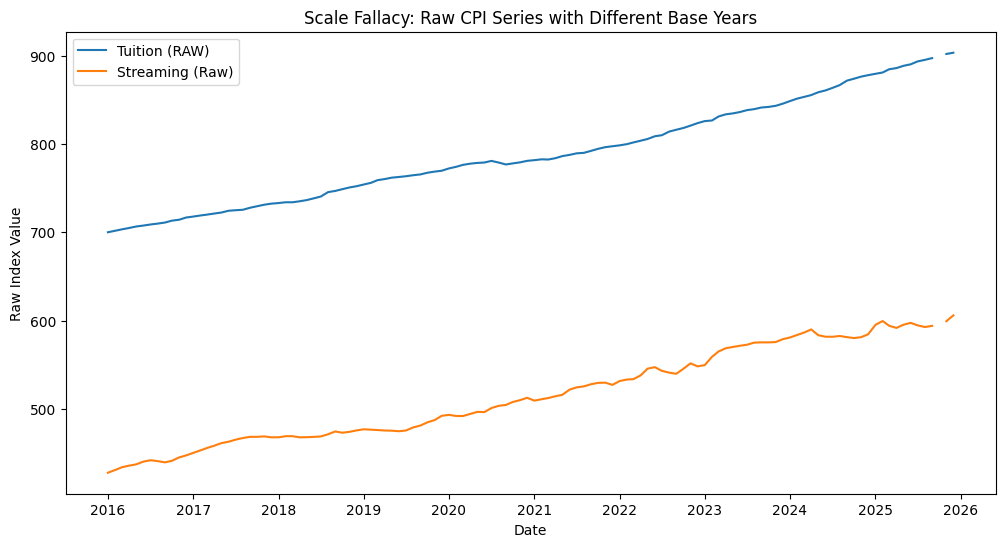

In [77]:
plt.figure(figsize=(12,6))

plt.plot(df.index, df['Tuition'], label='Tuition (RAW)')
plt.plot(df.index, df['Streaming'], label='Streaming (Raw)')

plt.title("Scale Fallacy: Raw CPI Series with Different Base Years")
plt.xlabel("Date")
plt.ylabel("Raw Index Value")
plt.legend()
plt.show()

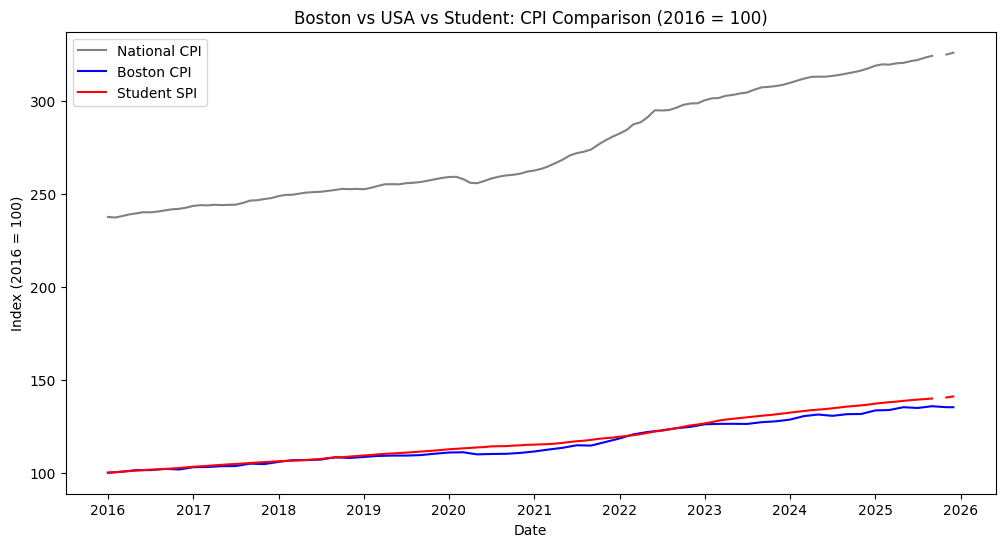

In [78]:
# Boston-Cambridge-Newton CPI (FRED series code)
BOSTON_CPI_CODE = 'CUURA103SA0'  # Consumer Price Index for All Urban Consumers: All Items in Boston-Cambridge-Newton, MA-NH (CBSA)

# Fetch Boston CPI series from FRED
boston_cpi_raw = fred.get_series(BOSTON_CPI_CODE)

# Ensure datetime indexes
boston_cpi_raw.index = pd.to_datetime(boston_cpi_raw.index)
df.index = pd.to_datetime(df.index)

# Re-index Boston CPI so 2016-01-01 = 100
base_date = pd.Timestamp('2016-01-01')
boston_base = boston_cpi_raw.loc[base_date]
boston_cpi_indexed = (boston_cpi_raw / boston_base) * 100

# Align Boston CPI to df's index (handle missing values if Boston is monthly/bimonthly)
boston_cpi_aligned = (
    boston_cpi_indexed
    .reindex(df.index)
    .interpolate(method='time')
    .ffill()
    .bfill()
)

# Plot: National CPI (Grey), Boston CPI (Blue), Student SPI (Red)
plt.figure(figsize=(12,6))

plt.plot(df.index, df['Official_CPI'], label='National CPI', color='grey')
plt.plot(df.index, boston_cpi_aligned, label='Boston CPI', color='blue')
plt.plot(df_indexed.index, df_indexed['Student_SPI'], label='Student SPI', color='red')

plt.title("Boston vs USA vs Student: CPI Comparison (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index (2016 = 100)")
plt.legend()
plt.show()